In [1]:
%matplotlib inline
#import deepdish as dd
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp

Using Numpy backend.


In [2]:
nostop = True
if nostop == True:
    embeddings=np.load("Exp1-NYT4-IGBA-embeddings.npy")
else:
    embeddings=np.load("Exp1-NYT4-IGBA-embeddings-stop.npy")
print(embeddings.shape)

(789, 100)


In [3]:
in_small = np.load('CH2020_50/in_small.npy')
out_small = np.load('CH2020_50/out_small.npy')

In [4]:
inputDataTesting=embeddings

averages = np.empty((len(inputDataTesting),embeddings.shape[1]))

print(averages.shape)

for num in range(len(inputDataTesting)):
        if num == 0:
            averages[num] = inputDataTesting[num]
        else:
            #inputAverageTesting[num] = ((num * inputAverageTesting[num-1]) + inputDataTesting[num]) / (num + 1)
            #nyt4[num] = ((.95*num * nyt4[num-1]) + 1.05*inputDataTesting[num]) / (num + 1)
            averages[num] = ((.75*num * averages[num-1]) + 1.25*inputDataTesting[num]) / (num + 1)
            #averages[num] = ((.95*num * averages[num-1]) + 1.05*inputDataTesting[num]) / (num + 1)
            #nyt4[num] = ((num * nyt4[num-1]) + inputDataTesting[num]) / (num + 1)


(789, 100)


In [5]:
# set the seed
res_seed = 4 #4
numNode = 100
vectorDim = 100
np.random.seed(res_seed)

# set up the reservoir
# leakingRate=0.2 changing too fast, mutliple with 0.05; changed
esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

# train the reervoir with a new seed
esn.fit(in_small, out_small, transientTime="Auto", verbose=1)
    

#run the reservoir
states = np.empty((0,numNode))
prediction,states  = esn.predict(inputDataTesting)
states = states.T
print(states.shape)
states = states[:,101:]
print(states.shape)
print(prediction.shape)

    


100% (9601 of 9601) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


(789, 201)
(789, 100)
(789, 100)


In [6]:
seg_no = 10
# 2 set up the segmentation HMM
ev1 = brainiak.eventseg.event.EventSegment(seg_no)
ev1.fit(embeddings)



EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

In [7]:

ev2 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
ev2.fit(averages)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

In [8]:

ev3 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
ev3.fit(states)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

In [9]:
for j in range(states.shape[1]):
    mean = states[:,j].mean()
    if abs(mean) > 0.01:
        states[:,j] = states[:,j]/mean

for j in range(embeddings.shape[1]):
    mean = embeddings[:,j].mean()
    if abs(mean) > 0.01:
        embeddings[:,j] = embeddings[:,j]/mean
        
for j in range(averages.shape[1]):
    mean = averages[:,j].mean()
    if abs(mean) > 0.001:
        averages[:,j] = averages[:,j]/mean        

embedding bounds:  [ 73 136 277 342 421 491 565 598 699]
integrator bounds:  [  4  71 137 195 279 337 424 564 693]
Reservoir bounds:  [ 94 145 199 291 429 506 585 634 716]


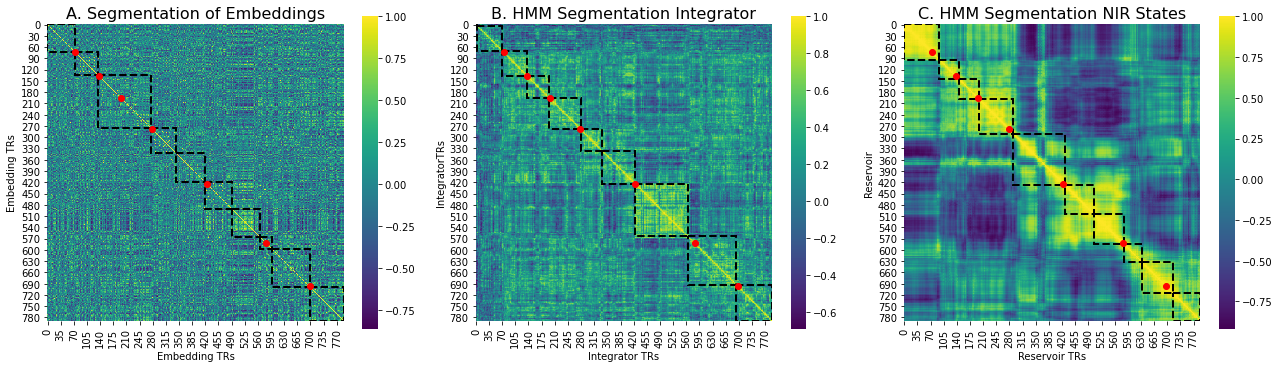

In [10]:
nTR=embeddings.shape[0]

fig=plt.figure(figsize=(18,5))

# embeddings
plt.subplot(1,3,1)

edge='black'

if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro')    

sns.heatmap(np.corrcoef(embeddings),cmap='viridis', square=True)


bounds1 = np.where(np.diff(np.argmax(ev1.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds1,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('embedding bounds: ',bounds1)    
    
plt.title('A. Segmentation of Embeddings', fontsize = 16)
plt.xlabel('Embedding TRs')
plt.ylabel('Embedding TRs')

 



# averages

plt.subplot(1,3,2)
color='jet'
#color='gist_rainbow'
edge='black'
scale1=0.825
scale2=0.9


#ground  68 349 464 557

if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro') 


#plt.imshow(np.corrcoef(igba),vmin=scale1, cmap=color)
#plt.imshow(np.corrcoef(igba))

sns.heatmap(np.corrcoef(averages),cmap='viridis', square=True)




bounds2 = np.where(np.diff(np.argmax(ev2.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds2,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
plt.title('B. HMM Segmentation Integrator', fontsize=16)

plt.xlabel('Integrator TRs')
plt.ylabel('IntegratorTRs')
print('integrator bounds: ',bounds2)


# states

plt.subplot(1,3,3)
color='jet'
#color='gist_rainbow'
edge='black'
scale1=0.825
scale2=0.9


#ground  74 137 197  278 424 583 698
if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro') 


#plt.imshow(np.corrcoef(igba),vmin=scale1, cmap=color)
#plt.imshow(np.corrcoef(igba))

sns.heatmap(np.corrcoef(states),cmap='viridis', square=True)




bounds3 = np.where(np.diff(np.argmax(ev3.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds3,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
plt.title('C. HMM Segmentation NIR States', fontsize=16)

plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir')
print('Reservoir bounds: ',bounds3)





fig.tight_layout()

if nostop == True:
    plt.savefig('HMM_NYT4-IGBA-revision.png', dpi=600)
else:
    plt.savefig('HMM_NYT4-IGBA-revision-nostop.png', dpi=600)


In [11]:
if nostop == True:
    g = [74, 137, 197,  278, 424, 583, 698]
else:
    g = [131, 233, 337, 470, 706, 939, 1126]
ground = np.array(g)

    

In [12]:

print(ground)
print(bounds1)
print(bounds2)
print(bounds3)





[ 74 137 197 278 424 583 698]
[ 73 136 277 342 421 491 565 598 699]
[  4  71 137 195 279 337 424 564 693]
[ 94 145 199 291 429 506 585 634 716]


p = 0.0035462871179479933


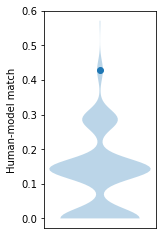

In [19]:
bounds = bounds3
human_bounds = ground+2
np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in human_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(human_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

In [14]:
print(match)

[0.42857143 0.         0.14285714 ... 0.         0.28571429 0.        ]


In [15]:
# works for .2 - .05